In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [27]:
# --- 1. 파라미터 및 디바이스 설정 ---
actions = ['hello', 'come', 'spin']
num_classes = len(actions)
data_files = [
    'dataset/seq_hello.npy',  # 라벨: 1
    'dataset/seq_come.npy',  # 라벨: 0
    'dataset/seq_spin.npy'   # 라벨: 2
]

# Keras input_shape=(30, 100) 기반
seq_length = 30
input_size = 100

# 하이퍼파라미터
epochs = 100
batch_size = 64
learning_rate = 0.001
model_save_path = 'models/gesture_model.pt'

# 디바이스 설정 (GPU 우선 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [28]:
# --- 2. 데이터 및 라벨 생성 ---
# Keras 코드의 x_data (data.shape (2603, 30, 100) 기준)
# (x_data 로드)
data_hello = np.load(data_files[0])
data_come = np.load(data_files[1])
data_spin = np.load(data_files[2])

x_data = np.concatenate([data_hello, data_come, data_spin], axis=0)

# (y_data 생성)
labels_hello = np.full(len(data_come), 0)
labels_come = np.full(len(data_hello), 1)
labels_spin = np.full(len(data_spin), 2)

y_data = np.concatenate([labels_hello, labels_come, labels_spin], axis=0)

print(f"X data shape: {x_data.shape}") # (2603, 30, 100)
print(f"Y data shape: {y_data.shape}") # (2603,)

X data shape: (2482, 30, 100)
Y data shape: (2482,)


In [29]:
# --- 3. 데이터 분리 및 DataLoader 생성 ---
# Keras와 동일 (sklearn 사용)
x_train, x_val, y_train, y_val = train_test_split(
    x_data, 
    y_data, 
    test_size=0.1, 
    random_state=2021, 
    stratify=y_data # 라벨 비율 유지
)

# NumPy -> PyTorch Tensor로 변환
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long) # CrossEntropyLoss는 long 타입 인덱스 필요
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Dataset 및 DataLoader 생성
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [30]:
# --- 4. PyTorch 모델 정의 ---
# Keras: LSTM(64, activation='relu') + Dense(32, 'relu') + Dense(3, 'softmax')
class GestureModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(GestureModel, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            batch_first=True # (batch, seq, feature)
        )
        
        # Keras: LSTM(activation='relu')는 LSTM의 출력(h_n)에 ReLU를 적용
        self.relu1 = nn.ReLU()
        
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(32, num_classes)
        # Keras: 'softmax'는 nn.CrossEntropyLoss에 포함되므로 여기서는 제외

    def forward(self, x):
        # Keras LSTM은 마지막 hidden state만 반환
        # PyTorch LSTM은 (output_seq, (h_n, c_n)) 반환
        _, (h_n, _) = self.lstm(x)
        
        # h_n shape: (num_layers, batch_size, hidden_size)
        x = h_n[-1] # 마지막 레이어의 hidden state
        
        # Keras의 activation='relu' 적용
        x = self.relu1(x)
        
        x = self.fc1(x)
        x = self.relu2(x)
        
        # 'softmax'가 없는 raw logits 반환
        x = self.fc2(x)
        return x

model = GestureModel(input_size, 64, num_classes).to(device)

In [31]:
# --- 5. 컴파일 (손실 함수, 옵티마이저, 스케줄러) ---
# Keras: optimizer='adam'
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Keras: loss='categorical_crossentropy'
# PyTorch: nn.CrossEntropyLoss (Softmax + NLLLoss)
loss_fn = nn.CrossEntropyLoss()

# Keras: ReduceLROnPlateau(monitor='val_acc')
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10)

In [32]:
# --- 6. 학습 루프 (model.fit + Callbacks) ---

# Keras ModelCheckpoint에 해당
best_val_acc = 0.0
os.makedirs('models', exist_ok=True)

# Keras history 객체에 해당
history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}

print("Training start...")

for epoch in range(epochs):
    
    # --- 훈련 (Train) ---
    model.train() # 훈련 모드
    train_loss = 0.0
    all_train_preds = []
    all_train_labels = []

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # 순전파
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = loss_fn(outputs, y_batch)
        
        # 역전파
        loss.backward()
        optimizer.step()
        
        # 통계
        train_loss += loss.item() * x_batch.size(0)
        _, predicted = torch.max(outputs.data, 1)
        all_train_preds.extend(predicted.cpu().numpy())
        all_train_labels.extend(y_batch.cpu().numpy())

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = accuracy_score(all_train_labels, all_train_preds)
    
    
    # --- 검증 (Validation) ---
    model.eval() # 평가 모드
    val_loss = 0.0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad(): # 그래디언트 계산 중지
        for x_batch_val, y_batch_val in val_loader:
            x_batch_val, y_batch_val = x_batch_val.to(device), y_batch_val.to(device)
            
            val_outputs = model(x_batch_val)
            loss = loss_fn(val_outputs, y_batch_val)
            
            val_loss += loss.item() * x_batch_val.size(0)
            _, predicted = torch.max(val_outputs.data, 1)
            all_val_preds.extend(predicted.cpu().numpy())
            all_val_labels.extend(y_batch_val.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_val_acc = accuracy_score(all_val_labels, all_val_preds)
    
    # history에 기록
    history['loss'].append(avg_train_loss)
    history['acc'].append(avg_train_acc)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(avg_val_acc)
    
    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} Acc: {avg_train_acc:.4f} | Val Loss: {avg_val_loss:.4f} Val Acc: {avg_val_acc:.4f}")
    
    # --- Keras 콜백 구현 ---
    # 1. ReduceLROnPlateau
    scheduler.step(avg_val_acc) # val_acc 모니터링
    
    # 2. ModelCheckpoint (save_best_only, monitor='val_acc')
    if avg_val_acc > best_val_acc:
        print(f"Validation accuracy improved ({best_val_acc:.4f} -> {avg_val_acc:.4f}). Saving model...")
        best_val_acc = avg_val_acc
        # Keras의 .h5와 달리 PyTorch는 모델의 가중치(state_dict)를 저장
        torch.save(model.state_dict(), model_save_path)

print("Training finished.")

Training start...
Epoch [1/100] | Train Loss: 0.8976 Acc: 0.8285 | Val Loss: 0.6057 Val Acc: 0.9759
Validation accuracy improved (0.0000 -> 0.9759). Saving model...
Epoch [2/100] | Train Loss: 0.3309 Acc: 0.9798 | Val Loss: 0.1347 Val Acc: 0.9839
Validation accuracy improved (0.9759 -> 0.9839). Saving model...
Epoch [3/100] | Train Loss: 0.0909 Acc: 0.9857 | Val Loss: 0.0723 Val Acc: 0.9839
Epoch [4/100] | Train Loss: 0.0620 Acc: 0.9857 | Val Loss: 0.0570 Val Acc: 0.9839
Epoch [5/100] | Train Loss: 0.0481 Acc: 0.9857 | Val Loss: 0.0448 Val Acc: 0.9839
Epoch [6/100] | Train Loss: 0.0364 Acc: 0.9857 | Val Loss: 0.0318 Val Acc: 0.9839
Epoch [7/100] | Train Loss: 0.0290 Acc: 0.9857 | Val Loss: 0.0227 Val Acc: 0.9839
Epoch [8/100] | Train Loss: 0.0180 Acc: 0.9933 | Val Loss: 0.0135 Val Acc: 1.0000
Validation accuracy improved (0.9839 -> 1.0000). Saving model...
Epoch [9/100] | Train Loss: 0.0135 Acc: 0.9978 | Val Loss: 0.0139 Val Acc: 0.9960
Epoch [10/100] | Train Loss: 0.0215 Acc: 0.9933 |

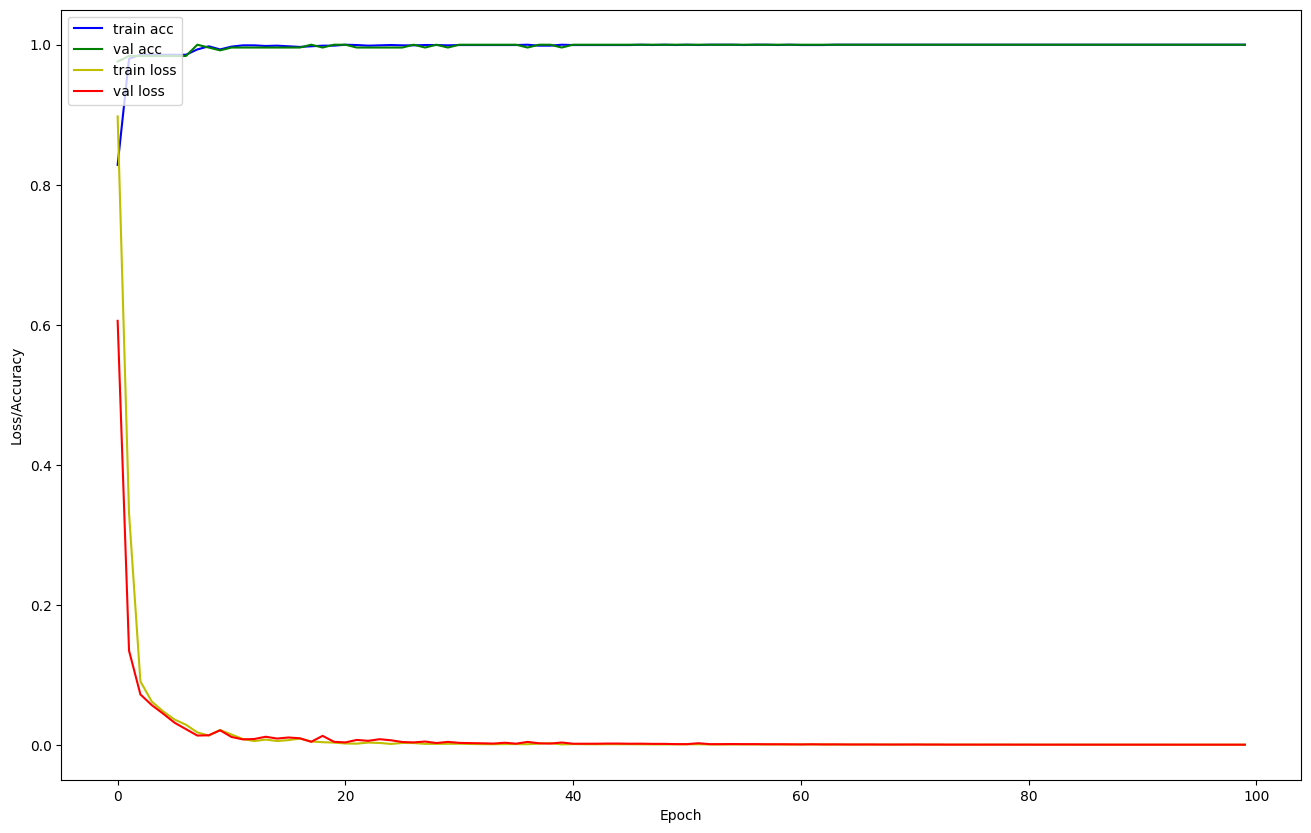

In [33]:
# --- 7. 결과 플로팅 ---
# Keras 코드와 거의 동일 (history.history['...'] -> history['...'])
plt.figure(figsize=(16, 10))
plt.plot(history['acc'], 'b', label='train acc')
plt.plot(history['val_acc'], 'g', label='val acc')
plt.plot(history['loss'], 'y', label='train loss')
plt.plot(history['val_loss'], 'r', label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='upper left')
plt.show()